# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
import warnings
from constants import *
import math
import os
import random
import matplotlib.pyplot as plt
import dill
from functools import reduce

# Helper Methods

In [2]:
def generate_random_sample(X, size):
    '''
    Given a list X, 
    generate random samples of given size
    '''
    Z_temp = random.sample(list(X), size)
    
    #Concatenation
    Z = [Z_temp[0]]
    for val in Z_temp[1:]:
        Z = np.concatenate([Z,[val]])
    
    return Z

def convert_values_to_list(list_val):
    '''
    Given a list X = [1 2 3] , 
    return X = [[1],[2],[3]]
    '''
    X = []
    for i in list_val:
        X.append([i])
    return X

def conversion_list_of_list(X, DIMENSION):
    '''
    Given a list X with values in lists,
    X = [[ 3  2  2],[4 8 10]]
    Convert each value to a list
    Return list of lists, array of lengths of each sequence
    X = [[3] [2] [2] [4] [8] [10]]
    ''' 
    X_new = []
    length = len(X)
    for idx, val_list in enumerate(X):
        Y = []
        for val in val_list:
            Y.append([val])
        X_new.append(Y)

    #Concatenation
    Z = X_new[0]
    for val_list in X_new[1:]:
        Z = np.concatenate([Z,val_list])

    # assign array of lengths for HMM
    lengths = [DIMENSION]*length
    
    return Z,lengths

#Calculate likelihood for given sequence according to given HMMs and return HMM
def likelihood_sequence(sequence, HMM_array):
    '''
    Given list of K HMMs and sequence,
    determines likelihood of sequence under all HMM models
    Returns index of HMM which has max likelihood
    ''' 
    scores = []
    length = [len(sequence)]
    for i, HMM in enumerate(HMM_array):
        calculated_score = HMM.score(sequence, length)
        scores.append(calculated_score)
    idx = scores.index(max(scores))
    return idx

def HMM_model_stats(model):
    '''
    Details of HMM model
    ''' 
    print("*************************************")
    print("Transition matrix")
    print(model.transmat_)
    print("*************************************")
    print("Means and stds of each hidden state")
    for i in range(model.n_components):
        print("Hidden state {0}".format(i))
        print("mean = ", model.means_[i])
        print("std = ", [np.sqrt(model.covars_[i])])
        print()

def BIC(model,X,lengths):
    LogLikelihood = model.score(X,lengths)
    num_hidden_states = model.n_components
    # D counts transition matrix (emission estimated by PDF), means = num_hidden_states  
    # covariance matrix = num_hidden_states
    D = num_hidden_states**2 + 2*num_hidden_states
    BIC = LogLikelihood - (D/2)*np.log(len(X))
    return BIC
    
def BIC_array(HMM_array,X_i):
    BIC_total = 0
    for i in range(len(X_i)):
        model = HMM_array[i]
        X, lengths = conversion_list_of_list(X_i[i],DIMENSION)
        BIC_total+= BIC(model,X,lengths)
    return BIC_total

def likelihood_array(HMM_array,X_i):
    likelihood_total = 0
    for i in range(len(X_i)):
        if(len(X_i[i])>=HMM_array[i].n_components):
            model = HMM_array[i]
            X, lengths = conversion_list_of_list(X_i[i],DIMENSION)
            LogLikelihood = model.score(X,lengths)
            likelihood = LogLikelihood 
            likelihood_total+= likelihood
    return likelihood_total

def plot_BIC(list_k, BIC_score):
    fig = plt.subplot(111)
    plt.plot(list_k, BIC_score, marker='o')  
    plt.xlabel('Value of K')
    plt.ylabel('Objective')
    plt.title('BIC')
    plt.show() 

def print_stats(assignments,length):
    for i in range(length):
        if(i%100==0):
            print(assignments[i])   

# Merge data

In [ ]:
previous = 'RPKMOutput/GeneNames/RNASeq/geneTXCD_RPKMoutput_'
timepoints = ['ATCACG-s_6_1_genome.txt','TTAGGC-s_6_1_genome.txt',
             'CAGATC-s_6_1_genome.txt','GCCAAT-s_6_1_genome.txt',
             'CTTGTA-s_6_1_genome.txt'
            ]
dataframes = []
for idx,file in enumerate(timepoints):
    df = pd.read_csv(previous+file, sep="	", na_values=['-'])
    df = df.dropna(how='any')
    df = df[['AccNum', 'GeneName','cdReads',
       'cdRPKM']]
    df.rename(columns={'cdRPKM':'cdRPKM'+str(idx), 'cdReads':'cdReads'+str(idx)}, inplace=True)
    dataframes.append(df)

In [ ]:
df_rnaseq = reduce(lambda left,right: pd.merge(left,right,on=['AccNum','GeneName']), dataframes)

In [ ]:
df_rnaseq.head()

In [ ]:
# df_rnaseq.to_csv('RPKMOutput/RNASeq.txt',sep=' ',index=False)

In [ ]:
previous = 'RPKMOutput/GeneNames/RPF/geneTXCD_RPKMoutput_'
timepoints = ['ATCACG-s_7_1_genome.txt','TTAGGC-s_7_1_genome.txt',
             'CAGATC-s_7_1_genome.txt','GCCAAT-s_7_1_genome.txt',
             'CTTGTA-s_7_1_genome.txt'
            ]
dataframes = []
for idx,file in enumerate(timepoints):
    df = pd.read_csv(previous+file, sep="	", na_values=['-'])
    df = df.dropna(how='any')
    df = df[['AccNum', 'GeneName','cdReads',
       'cdRPKM']]
    df.rename(columns={'cdRPKM':'cdRPKM'+str(idx), 'cdReads':'cdReads'+str(idx)}, inplace=True)
    dataframes.append(df)
df_rpf = reduce(lambda left,right: pd.merge(left,right,on=['AccNum','GeneName']), dataframes)
df_rpf.head()

In [ ]:
# df_rpf.to_csv('RPKMOutput/RPF.txt',sep=' ',index=False)

In [ ]:
# df_rnaseq = df_rnaseq[['AccNum','GeneName', 'cdRPKM0', 'cdRPKM1',
#        'cdRPKM2', 'cdRPKM3', 'cdRPKM4']]
# df_rpf = df_rpf[['AccNum','GeneName', 'cdRPKM0', 'cdRPKM1',
#        'cdRPKM2', 'cdRPKM3', 'cdRPKM4']]
df_TE = reduce(lambda left,right: pd.merge(left,right,on=['AccNum','GeneName']), [df_rnaseq,df_rpf])
df_TE.head()

In [ ]:
df_TE[['cdRPKM0_x']] = df_TE[['cdRPKM0_x']].div(df_TE['cdRPKM0_y'].values,axis=0)
df_TE[['cdRPKM1_x']] = df_TE[['cdRPKM1_x']].div(df_TE['cdRPKM1_y'].values,axis=0)
df_TE[['cdRPKM2_x']] = df_TE[['cdRPKM2_x']].div(df_TE['cdRPKM2_y'].values,axis=0)
df_TE[['cdRPKM3_x']] = df_TE[['cdRPKM3_x']].div(df_TE['cdRPKM3_y'].values,axis=0)
df_TE[['cdRPKM4_x']] = df_TE[['cdRPKM4_x']].div(df_TE['cdRPKM4_y'].values,axis=0)
for i in range(0,5):
    df_TE.rename(columns={'cdRPKM'+str(i)+'_x':'TE'+str(i)}, inplace=True)


In [ ]:
df_TE.keys()

In [ ]:
# df_TE.to_csv('RPKMOutput/TE.txt',sep=' ',index=False)

# Load Data and Clean

In [ ]:
df_rnaseq.keys()
df_TE.keys()

In [10]:
#Dataset
# df_rnaseq = df_rnaseq[(df_rnaseq['cdReads0'] >= 50) & (df_rnaseq['cdReads1'] >= 50) & (df_rnaseq['cdReads2'] >= 50)& (df_rnaseq['cdReads3'] >= 50)& (df_rnaseq['cdReads4'] >= 50)]
df_TE = pd.read_csv('RPKMOutput/TE.txt', sep="\t", na_values=['-'])
df_main = df_TE[['TE0', 'TE1', 'TE2', 'TE3', 'TE4']]
LENGTH,DIMENSION = df_main.shape
print("Dataset size is",LENGTH)
print("Features are", DIMENSION)
df_main.head(5)
X = df_main.values
print("****************************")
print("First 5 values\n",X[:5])

Dataset size is 5576
Features are 5
****************************
First 5 values
 [[ 1.31159283  1.23984226  1.41108413  1.62303084  1.26630538]
 [ 1.89815922  1.91444197  2.39542881  2.59610252  1.8943366 ]
 [ 0.05129339  0.20778105  0.36115891  0.62002836  0.068366  ]
 [ 0.55636309  0.55178626  0.26312682  0.28484416  0.34035201]
 [ 0.23795297  0.49359885  0.79084318  0.3908574   0.45538912]]


In [11]:
df_TE.head(5)

,AccNum,GeneName,TE0,TE1,TE2,TE3,TE4,foldTE1,foldTE2,foldTE3,foldTE4
0,NM_017847,ODR4,1.311593,1.239842,1.411084,1.623031,1.266305,-0.071751,0.099491,0.311438,-0.045287
1,NM_001003803,ATP5S,1.898159,1.914442,2.395429,2.596103,1.894337,0.016283,0.497270,0.697943,-0.003823
2,NM_016647,THEM6,0.051293,0.207781,0.361159,0.620028,0.068366,0.156488,0.309866,0.568735,0.017073
3,NM_016640,MRPS30,0.556363,0.551786,0.263127,0.284844,0.340352,-0.004577,-0.293236,-0.271519,-0.216011
4,NM_001080825,TMEM120B,0.237953,0.493599,0.790843,0.390857,0.455389,0.255646,0.552890,0.152904,0.217436


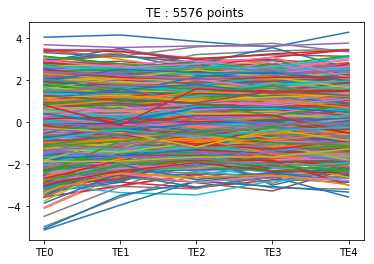

In [9]:
def plot_cluster(X,count):
    fig = plt.subplot(111)
    axes = plt.gca()
    var_plot_list = ['TE0','TE1','TE2','TE3','TE4']#['cdRPKM0','cdRPKM1','cdRPKM2','cdRPKM3','cdRPKM4']
    total=0
    for i in range(len(X)):
        fig.plot(var_plot_list, X[i])
        total+=1
    title = "TE : " + str(total) + " points "
    plt.title(title)
    plt.savefig('/Users/akankshitadash/Desktop/Cluster'+str(count)+'.png')
    plt.show()
plot_cluster(X,1)

In [29]:
# for idx,row in enumerate(X):
#     temp = X[idx,0]
#     X[idx,0]=0
#     X[idx,1]-=temp
#     X[idx,2]-=temp
#     X[idx,3]-=temp
#     X[idx,4]-=temp 
# print("First 5 log2 values after normalizing\n",X[:5])

# Arrays with HMM models for 1<=K<=20

In [30]:
HMM_K_ARRAYS = []
X_i_K_ARRAYS = []

# Check likelihood and do assignments

In [31]:
K_values = [16]

In [ ]:
for K in K_values:
    HMM_array = []
    X_i = []
    print("**************** K =", K ,"************************")
    for i in range(K):
        X_i.append([])
        
    NUM_ITERATIONS = 0
    NUM_CLUSTER_PREV = {}
    NUM_CLUSTER_NOW = {}
    
    # Sequences for initial HMM estimation
    # Make K subsets data of LENGTH
    for i in range(LENGTH):
        for j in range(K):
            if(i%K==j):
                X_i[j].append(list(X[i]))
                NUM_CLUSTER_PREV[i] = j
                
    for i in range(K):
        model = hmm.GaussianHMM(n_components=3,covariance_type='diag')
        X_temp, lengths = conversion_list_of_list(X_i[i],DIMENSION)
        model.fit(X_temp, lengths)
        HMM_array.append(model)
    
    likelihood_prev = likelihood_array(HMM_array,X_i)
    print("Likelihood for iteration",NUM_ITERATIONS,"is",likelihood_prev)
    NUM_ITERATIONS+=1
    while (True):
        # Assign all sequences to HMM models

        print("************ Check likelihood of sequence in HMM  *********")
        NUM_CLUSTER_NOW = {}
        for idx,x in enumerate(X):
            sequence = convert_values_to_list(x)
            hmm_index = likelihood_sequence(sequence, HMM_array)
            X_i[hmm_index].append(list(x))
            NUM_CLUSTER_NOW[idx] = hmm_index
        print("************ Checking likelihood done  *********")

        # Re-estimate parameters for new HMMs
        print("************ Re-estimating HMM *********")
        HMM_array_prev = HMM_array
        HMM_array = []
        for i in range(K):
            model = hmm.GaussianHMM(n_components=3,covariance_type='diag')
            if(len(X_i[i])>=model.n_components):
                X_temp, lengths = conversion_list_of_list(X_i[i], DIMENSION)
                model.fit(X_temp, lengths)
                HMM_array.append(model)
            else:
                HMM_array.append(HMM_array_prev[i])
        print("************ Re-estimation done *********")
        likelihood_curr = likelihood_array(HMM_array,X_i)
        print("Likelihood for iteration",NUM_ITERATIONS,"is",likelihood_curr)
        print("*****************************************")

        # if no reassignments, then break
        if ((NUM_CLUSTER_PREV == NUM_CLUSTER_NOW)):
            HMM_K_ARRAYS.append(HMM_array)
            X_i_K_ARRAYS.append(X_i)
            break
        else:
            # initialize empty subsets of data for next iteration
            X_i = []
            for i in range(K):
                X_i.append([])

            NUM_CLUSTER_PREV = NUM_CLUSTER_NOW
            print("Num iterations is:", NUM_ITERATIONS)
            NUM_ITERATIONS += 1
            likelihood_prev = likelihood_curr
    print("**********************************************************\n\n")

In [33]:
print(len(HMM_K_ARRAYS))
print(len(X_i_K_ARRAYS))

1
1


In [34]:
import seaborn as sns

def plot_cluster(X,count):
    fig = plt.subplot(111)
    axes = plt.gca()
    axes.set_ylim([-15,15])
    var_plot_list = ['TE0','TE1','TE2','TE3','TE4']#['cdRPKM0','cdRPKM1','cdRPKM2','cdRPKM3','cdRPKM4']
    total=0
    for i in range(len(X)):
        fig.plot(var_plot_list, X[i])
        total+=1
    title = "HMM "+ str(count)+" : " + str(total) + " points "
    plt.title(title)
    plt.savefig('/Users/akankshitadash/Desktop/Gene Ontology/5points/TE/Clusters/Cluster'+str(count)+'.png')
    plt.show()
    
def plot_heatmap(X,idx):
    plt.figure()
    sns.heatmap(X,vmin=-15, vmax=15)
    plt.title('Heatmap'+str(idx))
    plt.savefig('/Users/akankshitadash/Desktop/Gene Ontology/5points/TE/Heat Map/HeatMap'+str(idx+1)+'.png')
    plt.show()

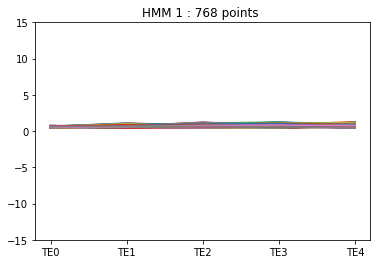

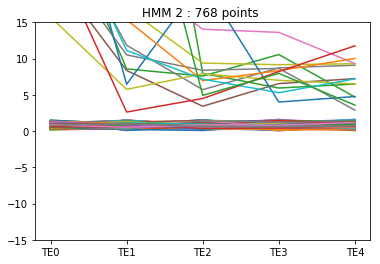

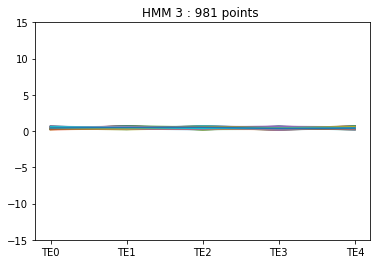

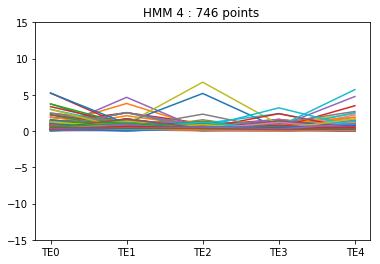

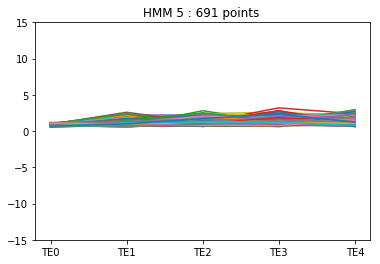

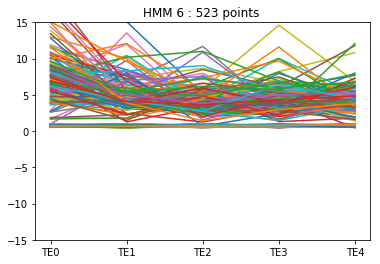

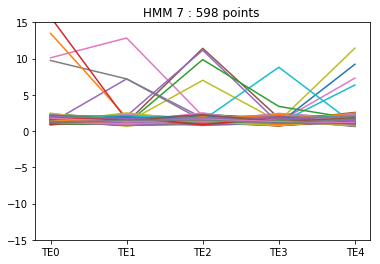

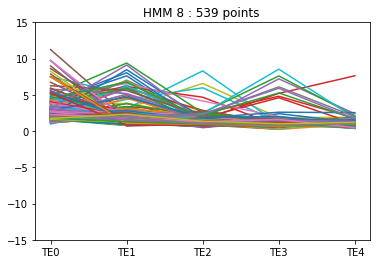

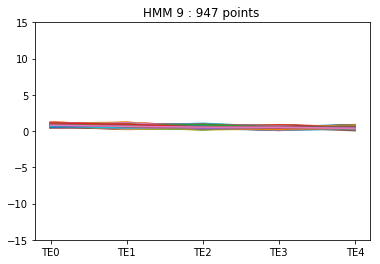

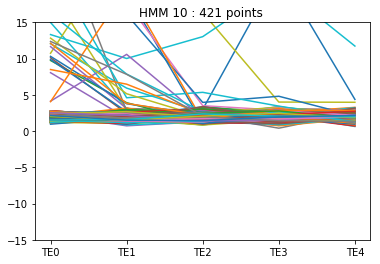

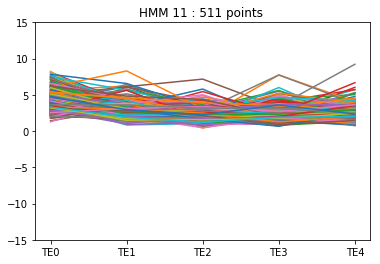

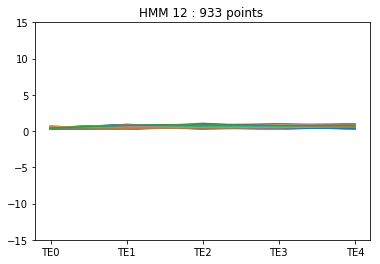

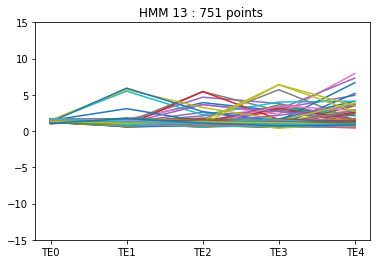

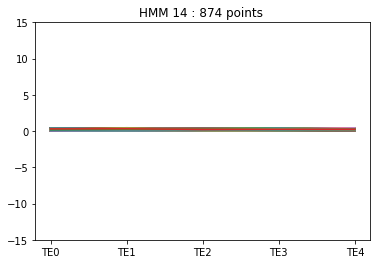

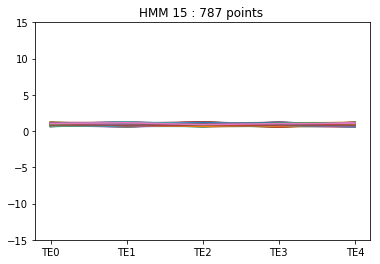

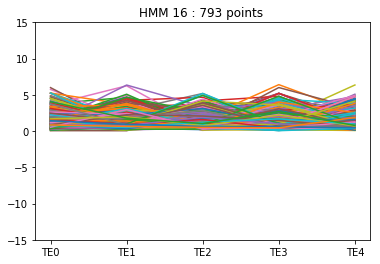

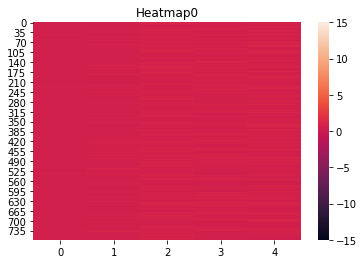

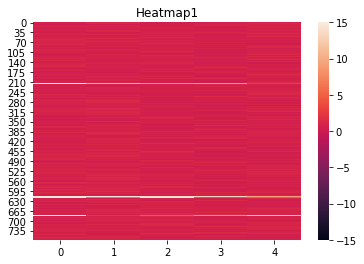

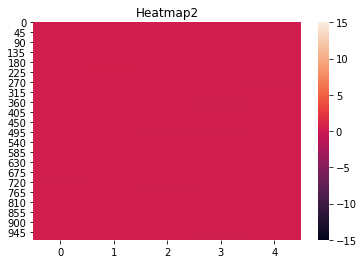

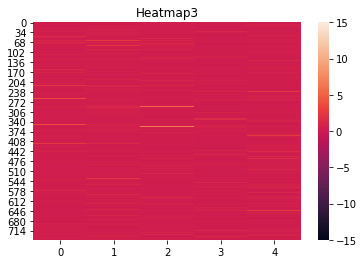

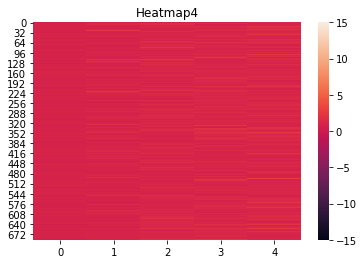

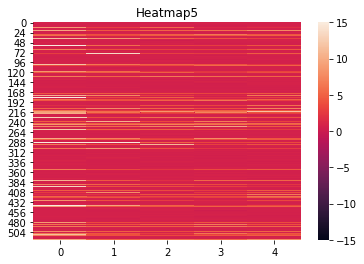

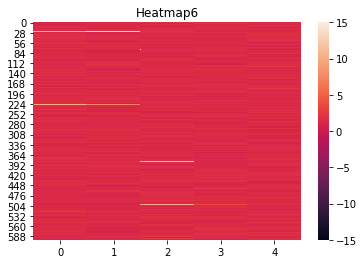

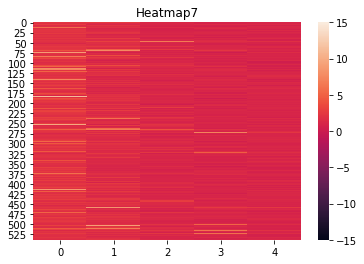

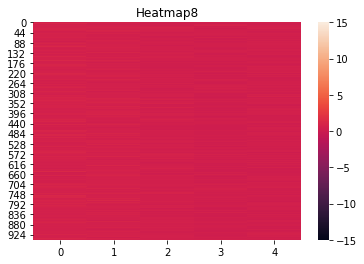

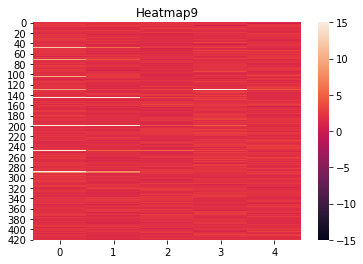

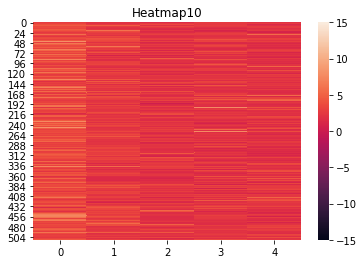

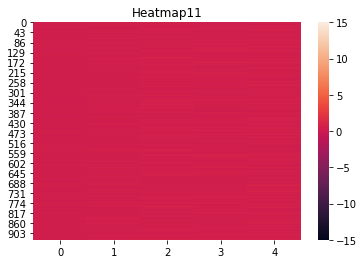

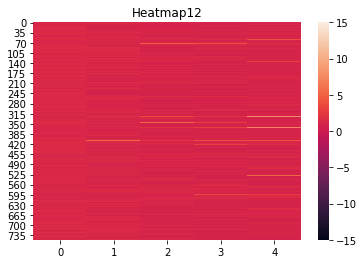

In [ ]:
for idx,X in enumerate(X_i_K_ARRAYS[0]):
    plot_cluster(X,idx+1)
for idx,X in enumerate(X_i_K_ARRAYS[0]):
    plot_heatmap(X,idx)

In [ ]:
df = pd.read_csv('RPKMOutput/TE.txt', sep=" ", na_values=['-'])
df = df.dropna()
df = df[['AccNum','GeneName','TE0','TE1','TE2','TE3','TE4']]

In [ ]:
for idx,x in enumerate(X_model):
    genes=[]
    acc_nums=[]
    for row in x:
        temp = (df.loc[(df['TE0'] == row[0])& (df['TE1']== row[1]) & (df['TE2']== row[2]) & (df['TE3']== row[3]) & (df['TE4']== row[4])])
        if(not temp.empty):
            genes.append(temp['GeneName'].values[0])
            acc_nums.append(temp['AccNum'].values[0])
    print(len(x),len(genes))
    with open('/Users/akankshitadash/Desktop/Gene Ontology/5points/TE/Gene Names/Gene'+str(idx+1)+'.txt','w') as f:
        for gene in genes:
            f.write("%s\n" % gene)
    with open('/Users/akankshitadash/Desktop/Gene Ontology/5points/TE/Gene Names/AccNum'+str(idx+1)+'.txt','w') as f:
        for acc_num in acc_nums:
            f.write("%s\n" % acc_num)